In [112]:
import pandas as pd
import plotly.express as px
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN


In [2]:
a4_data = pd.read_csv("./dataset/2023-02-08-DATA624-Assignment4-Data.csv")
a4_data.describe()
a4_data.head
# a4_data.columns

<bound method NDFrame.head of              0         1         2         3         4         5         6  \
0    -1.606951  0.873530  0.354386 -0.376583 -0.123913 -5.574885  0.115763   
1     0.704287 -1.828743 -0.116858  0.147165 -0.296007 -5.944087 -0.156580   
2     1.424599 -0.281860  0.841544 -0.655310  0.378469 -6.604756 -0.426063   
3     1.390018  0.289805  1.093028 -0.690624 -0.548168 -5.948213 -0.081209   
4     1.032563 -1.042404  1.019796  0.888428 -0.102096 -5.970099 -0.071962   
...        ...       ...       ...       ...       ...       ...       ...   
6165 -3.907976  2.522889 -2.677499  1.191893 -1.437921 -1.749991 -0.189743   
6166  3.330155 -4.534200  1.625227 -0.485558  0.914868 -0.527034 -0.507081   
6167 -3.300942 -2.333507 -1.022910 -2.212949  2.440453  2.567430 -0.558333   
6168  5.778613  0.536104  0.906734 -0.986751 -0.447457 -0.161881 -0.292931   
6169 -5.966899  0.599078  0.014040 -0.108468  0.145487  0.048156  0.036127   

             7         8         

##### Use Pandas Profiling to skim the dataset for data cleaning and column selections

In [ ]:
profile = ProfileReport(
    a4_data, 
    title="Nifty Profiling Report",
    # dark_mode=True,
    orange_mode=True,
    minimal=True,
)

In [ ]:
profile.to_file("profile_a4.html")

In [54]:
labels = a4_data.iloc[:,14]
a4_data_df = a4_data.iloc[:,:13]
a4_data_df

a4_data_df = pd.concat([
    pd.DataFrame(a4_data_df),
    pd.DataFrame(a4_data.iloc[:,14]),
],axis=1)
a4_data_df.columns = [str(x) for x in a4_data_df.columns]
last_col_name = a4_data_df.columns[-1]
# create a dictionary of column names to rename
new_col_names = {last_col_name: 'label'}
# rename the columns using the rename() method
a4_data_df = a4_data_df.rename(columns=new_col_names)
print(a4_data_df.shape)
a4_data_df.head()

(6170, 14)


,0,1,2,3,4,5,6,7,8,9,0.1,1.1,2.1,label
0,-1.606951,0.873530,0.354386,-0.376583,-0.123913,-5.574885,0.115763,6.322857,-0.133692,-0.235926,0.849269,0.972069,-0.785170,0
1,0.704287,-1.828743,-0.116858,0.147165,-0.296007,-5.944087,-0.156580,5.940719,0.056806,-0.048602,-0.441113,0.368587,-1.788952,0
2,1.424599,-0.281860,0.841544,-0.655310,0.378469,-6.604756,-0.426063,6.230854,-0.091393,0.036048,-1.214484,1.536237,-1.044251,0
3,1.390018,0.289805,1.093028,-0.690624,-0.548168,-5.948213,-0.081209,6.015520,0.032229,0.033835,-0.943463,1.642818,-0.378879,1
4,1.032563,-1.042404,1.019796,0.888428,-0.102096,-5.970099,-0.071962,6.030498,-0.015960,0.015448,-0.349584,0.828618,0.716666,0


##### Based on the result of profiling above, 3.1 column will be removed due to all constant zero value (will see how different it will be) 4.1 column will be keeped in the table, it might represent the target value.

#####  Use KMeans to get general idea of estiamted number of clusters, then apply other algorithms based on the range of K. Create blobs, circle and moons shape for each one test with three following algorithms and see which one has the best performances.

#### To discover how many clusters in the dataset (check all pairs), will use Agglomerative clustering (for detecting Large n_samples and n_clusters) and OPTICS (for detecting Large n_clusters and n_samples also for Large dataset, outlier removal, data reduction). The last one will use t-Distributed Stochastic Neighbor Embedding (t-SNE) to see how data separated into clusters. 

In [55]:
sscore = []
# starting with 2 clusters now becuase the silhouette isn't defined for 1
for i in range(2,10):
    kmeans = KMeans(
        n_clusters = i, # Number of clusters to find
        init = "k-means++", # How to place the initial cluster centroids,
        max_iter= 100, # Maximum number of iterations for the algorithm to run
        tol=0.0001, # Roughly how much the centroids need to change between iterations to keep going
    ).fit(
        a4_data_df
    )
    
    silhouette_avg = silhouette_score(a4_data_df, kmeans.labels_)
    sscore.append(silhouette_avg)
    
px.line(y = sscore,x = range(2,10), markers=True)

<AxesSubplot:xlabel='0', ylabel='1'>

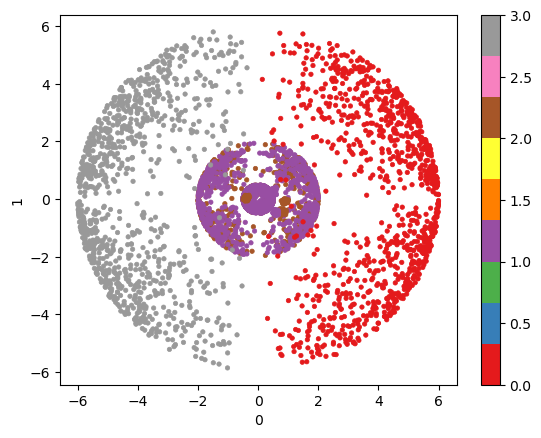

In [81]:
kmeans = KMeans(
        n_clusters = 4, # Number of clusters to find
        init = "k-means++", # How to place the initial cluster centroids,
        max_iter= 100, # Maximum number of iterations for the algorithm to run
        tol=0.0001, # Roughly how much the centroids need to change between iterations to keep going
    ).fit(
        a4_data_df
    )

data_kmeans =pd.concat([
    a4_data_df,
    pd.DataFrame(
        kmeans.labels_,
        columns=['cluster']
    ).astype('category')
], axis=1)

# create a color map based on unique values in 'cluster' column
color_map = plt.cm.get_cmap('Set1')
# convert 'cluster' column to a sequence of numbers
colors = data_kmeans['cluster'].astype('category').cat.codes

# plot scatter plot with colors based on 'cluster' column
data_kmeans.plot.scatter(x='0', y='1', c=colors, cmap=color_map, marker='o',s=10, linewidths=0.5)

In [150]:
kmeans = KMeans(
        n_clusters = 4, # Number of clusters to find
        init = "k-means++", # How to place the initial cluster centroids,
        max_iter= 100, # Maximum number of iterations for the algorithm to run
        tol=0.0001, # Roughly how much the centroids need to change between iterations to keep going
    ).fit(
        a4_data_df
    )

data_kmeans =pd.concat([
        a4_data_df,
        pd.DataFrame(
            kmeans.labels_,
            columns=['cluster']
        ).astype('category')
    ], axis=1)

fig = px.scatter(
    data_kmeans, 
    x='0', 
    y='1', 
    color='cluster',
    color_continuous_scale='Set1',
    width=800,
    height=600,
    title='Clustering with KMeans'
)
data_kmeans.to_csv('./dataset/a4_data_with_cluster.csv')

In [110]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
sscore = []

for i in range(2,10):
    clusters = AgglomerativeClustering(
        n_clusters = i, # Number of clusters to find
        # linkage="ward", #default
        linkage="average",
    ).fit(
        a4_data_df
    )
    
    silhouette_avg = silhouette_score(a4_data_df, clusters.labels_)
    sscore.append(silhouette_avg)
    
px.line(y = sscore,x = range(2,10), markers=True)


<AxesSubplot:xlabel='0', ylabel='1'>

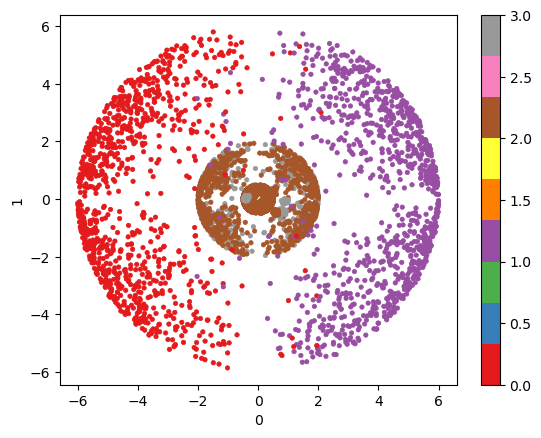

In [111]:
import matplotlib.pyplot as plt
# In this regard, single linkage is the worst strategy, and Ward gives the most regular sizes. 
# However, the affinity (or distance used in clustering) cannot be varied with Ward, thus for 
# non Euclidean metrics, average linkage is a good alternative. Single linkage, while not robust 
# to noisy data, can be computed very efficiently and can therefore be useful to provide hierarchical 
# clustering of larger datasets. Single linkage can also perform well on non-globular data.

clusters_agg = AgglomerativeClustering(
        n_clusters = 4, # Number of clusters to find
        # linkage="ward", #default
        linkage="average",
    ).fit(
        a4_data_df
    )

data_agg = pd.concat([
    a4_data_df,
    pd.DataFrame(
        clusters_agg.labels_,
        columns=['cluster']
    ).astype('category')
], axis=1)

# create a color map based on unique values in 'cluster' column
color_map = plt.cm.get_cmap('Set1')
# convert 'cluster' column to a sequence of numbers
colors = data_agg['cluster'].astype('category').cat.codes

# plot scatter plot with colors based on 'cluster' column
data_agg.plot.scatter(x='0', y='1', c=colors, cmap=color_map, marker='o',s=10, linewidths=0.5)

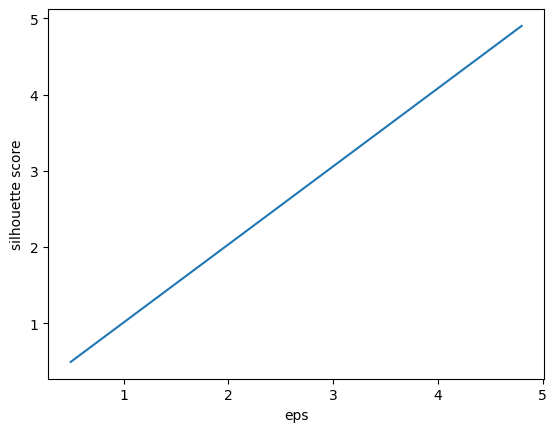

In [132]:
eps_values = np.arange(0.1, 5.1, 0.1)

scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps,min_samples=2)
    labels = dbscan.fit_predict(a4_data_df)
    has_negative = False
    for x in labels:
        if x < 0:
            has_negative = True
            break
    if has_negative == False:
        score = silhouette_score(a4_data_df, labels)
        scores.append([eps,score])

plt.plot(scores[0], scores[1])
plt.xlabel('eps')
plt.ylabel('silhouette score')
plt.show()

<AxesSubplot:xlabel='0', ylabel='1'>

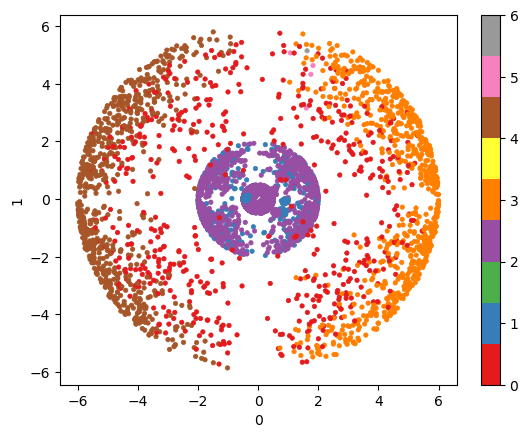

In [139]:
clusters = DBSCAN(
# eps= 0.5, # Max distance between two points to assign to same cluster 
eps= 2.5, # Max distance between two points to assign to same cluster 
# eps= 2, # Max distance between two points to assign to same cluster 
).fit(
    a4_data_df
)

data_dbscan = pd.concat([
    a4_data_df,
    pd.DataFrame(
        clusters.labels_,
        columns=['cluster']
    ).astype('category')
], axis=1)

# create a color map based on unique values in 'cluster' column
color_map = plt.cm.get_cmap('Set1')
# convert 'cluster' column to a sequence of numbers
colors = data_dbscan['cluster'].astype('category').cat.codes

# plot scatter plot with colors based on 'cluster' column
data_dbscan.plot.scatter(x='0', y='1', c=colors, cmap=color_map, marker='o',s=10, linewidths=0.5)


In [83]:
from sklearn.manifold import TSNE

/Users/sun/opt/anaconda3/envs/dataenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



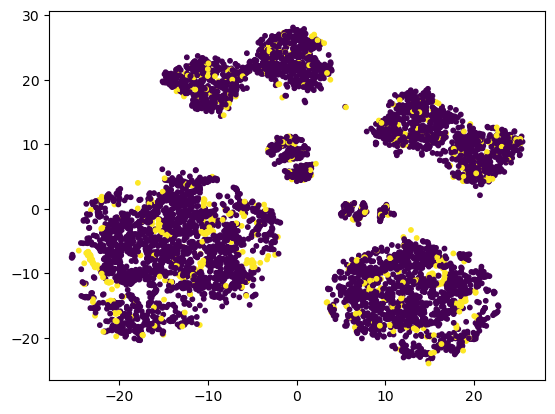

In [141]:
ts = TSNE(
    perplexity=100, # Roughly the "size" of the clusters to look for (original paper
                   # recommends in the 5-50 range, but in general should be less than
                   # then number of points in your dataset
    learning_rate="auto",
    n_iter=500,
    init='pca',
).fit_transform(a4_data_df)

plt.scatter(ts[:, 0], ts[:, 1], c=a4_data_df.label,s=10)
plt.show()

In [149]:
ts = TSNE(
    perplexity=100, # Roughly the "size" of the clusters to look for (original paper
                   # recommends in the 5-50 range, but in general should be less than
                   # then number of points in your dataset
    learning_rate="auto",
    n_iter=500,
    init='pca',
).fit_transform(a4_data_df)

px.scatter(
        x=ts[:, 0],
        y=ts[:, 1],
        color=a4_data_df['label'],
        width=600,
        height=600,
        title='t-SNE Visualization'
    )

/Users/sun/opt/anaconda3/envs/dataenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

